# Simplifying Deep Learning Model Deployment

In [1]:
import onnxruntime as rt
import tf2onnx
import os
import subprocess
import numpy as np
import pandas as pd

First, let's creat a dummy TF Keras model 

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
input_shape = 10
model = keras.Sequential(
    [
        keras.Input(shape=input_shape, name="input"),
        layers.Dense(128, activation="relu", name="layer1"),
        layers.Dense(64, activation="relu", name="layer2"),
        layers.Dense(1, activation="sigmoid", name="layer3"),
    ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 128)               1408      
                                                                 
 layer2 (Dense)              (None, 64)                8256      
                                                                 
 layer3 (Dense)              (None, 1)                 65        
                                                                 
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_________________________________________________________________


In [3]:
print(tf.__version__)

2.9.1


Then save it to the ./tf_model directory 

In [4]:
tensorflow_model_path = './tf_model'

In [5]:
model.save('./tf_model')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity t

In [6]:
!ls ./tf_model

assets            keras_metadata.pb saved_model.pb    variables


In [7]:
tensorflow_model_path = './tf_model/'

Now, we can use tf2onnx.convert to convert our TF model to Onnx format

In [8]:
proc = subprocess.run('python -m tf2onnx.convert --saved-model ./tf_model/ '
                      '--output model.onnx --opset 12'.split(),
                      capture_output=True)
print(proc.returncode)
print(proc.stdout.decode('ascii'))
print(proc.stderr.decode('ascii'))

0

/Users/tpalczew/opt/anaconda3/envs/BookML/lib/python3.7/runpy.py:125: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-08-15 02:53:06,197 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2022-08-15 02:53:06,324 - INFO - Signatures found in model: [serving_default].
2022-08-15 02:53:06,324 - WARNING - '--signature_def' not specified, using first signature: serving_default
2022-08-15 02:53:06,324 - INFO - Output names: ['layer3']
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-08-15 02:53:06,362 - WARNING - From /Users/tpalczew/opt/anaconda3/envs/BookML/lib/python3.7/site-packages/tf2onnx/tf_loader.py:706: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.gr

At this stage we are ready to create inference session with our Onnx model

In [9]:
providers = ['CPUExecutionProvider'] # select desired provider or use rt.get_available_providers()

In [10]:
model = rt.InferenceSession("model.onnx", providers=providers)

To showcase, how simple is to run inference let's use sample_google_scholar.csv dataset as in Chapter 3 and run inference using our dummy model

In [11]:
data = pd.read_csv("sample_google_scholar.csv")
data = data.dropna()
def convert_first_ten_characters_into_tensor(data):
    first_ten_characters = data[:10]
    converted = [ord(char)/256 for char in first_ten_characters]
    while len(converted) < 10:
        converted.append(0.0)
    return np.array(converted)

converted_affiliation = data['affiliation'].map(convert_first_ten_characters_into_tensor)
affiliation = np.vstack(converted_affiliation.values)
converted_email = data['email'].str.contains('.edu')
labels = converted_email.values

In [12]:
x = []
for elem in affiliation:
    x.append([float(el) for el in elem])

In [13]:
output_names = ['layer3']

Now, we can run predictions

In [14]:
onnx_pred = model.run( output_names, {"input": x} ) 

In these simple steps we performed inference using Onnx model obtained from converting a dummy TF Keras model. We can print our results now. 

In [15]:
print(onnx_pred)

[array([[0.5373258 ],
       [0.5373258 ],
       [0.5368283 ],
       [0.5368283 ],
       [0.5117777 ],
       [0.5368283 ],
       [0.5368283 ],
       [0.5165063 ],
       [0.5117777 ],
       [0.5432105 ],
       [0.5365961 ],
       [0.5493356 ],
       [0.5346542 ],
       [0.53177744],
       [0.5336821 ],
       [0.5274988 ],
       [0.5368283 ],
       [0.52151144],
       [0.5432105 ],
       [0.5432105 ],
       [0.5399585 ],
       [0.5368283 ],
       [0.5368283 ],
       [0.5368283 ],
       [0.5291359 ],
       [0.52276444],
       [0.5368283 ],
       [0.5472235 ],
       [0.5368283 ],
       [0.54499006],
       [0.5368283 ],
       [0.5290573 ],
       [0.5432105 ],
       [0.54848415],
       [0.54808044],
       [0.49349746],
       [0.52960664],
       [0.5315274 ],
       [0.5368283 ],
       [0.5273765 ],
       [0.5368283 ],
       [0.5269466 ],
       [0.5368283 ],
       [0.54808044],
       [0.5291049 ],
       [0.5368283 ],
       [0.5368283 ],
       [0.53

We can also conver TF models form checkpoint and graphdef formats using following commands:
```bash
python -m tf2onnx.convert --checkpoint tensorflow-model-meta-file-path --output model.onnx --inputs input0:0,input1:0 --outputs output0:0
```
and 
```bash
python -m tf2onnx.convert --graphdef tensorflow_model_graphdef-file --output model.onnx --inputs input0:0,input1:0 --outputs output0:0
```

## Let's convert our Onnx model back to TF version 

In [52]:
import onnx

In [53]:
from onnx_tf.backend import prepare

In [54]:
onnx_model = onnx.load('model.onnx')

In [55]:
tf_prep = prepare(onnx_model)

In [56]:
tf_prep.export_graph('tf_model.pb')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: tf_model.pb/assets


INFO:tensorflow:Assets written to: tf_model.pb/assets


In [57]:
model = tf.saved_model.load("tf_model.pb")

In [58]:
print(model)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f8250b85a10>


The same can be achieved by using command line script as follows
```
onnx-tf convert -i model.onnx -o tensorflow_model_file
```

In addition, one can conver onnx model to TF Keras version uisng onnx2keras and providing input name/s
```python
from onnx2keras import onnx_to_keras
k_model = onnx_to_keras(onnx_model, ['input'])
```
In a similar way, one can convert PyTorch model to Onxx using onnx2pytorch
```python
from onnx2pytorch import ConvertModel
onnx_model = onnx.load(”model.onnx”)
pytorch_model = ConvertModel(onnx_model)
```
Lastly, PyTroch model can be converted to Onnx using built-in functionality:
```python
torch.onnx.export(
    pytorch_model,                # model being run
    dummy_input,                  # model input (or a tuple for multiple inputs)
    onnx_model_path            # where to save the model (can be a file or file-like object) )
```

ONNX is a layer between training frameworks and deployment environments. While ONNX file defines an exchange format, there also exists ONNX Runtime (ORT) which supports hardware-agnostic acceleration for ONNX models.
In this example, we have presented how to run inference using ORT and a few typical conversions from and to ONNX format.

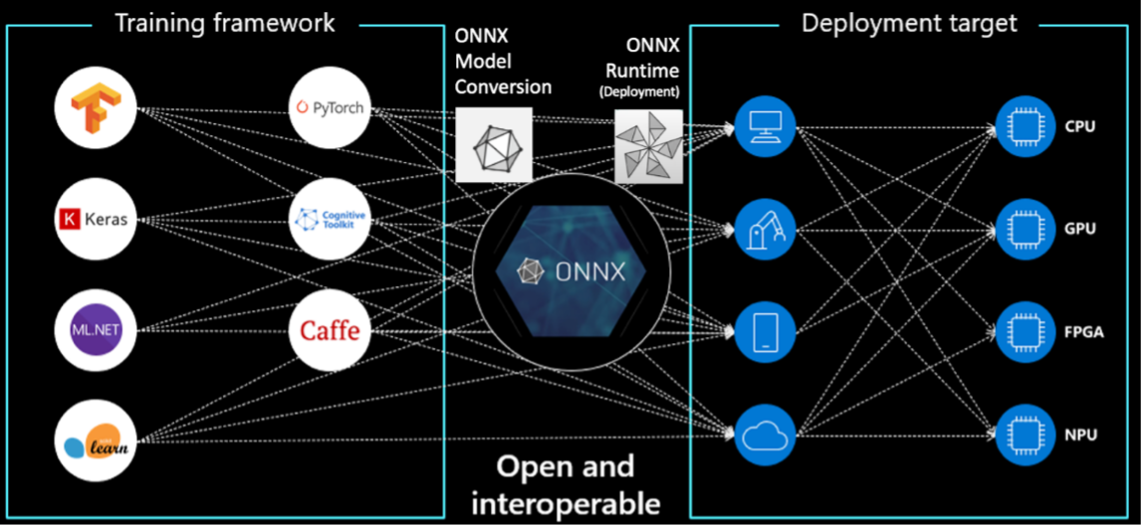

In [101]:
from IPython.display import Image
Image("onnx.png")